In [1]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from konlpy.tag import Twitter
twt = Twitter()
from hanspell import spell_checker
import re
from konlpy.tag import Okt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from konlpy.tag import Kkma
from sklearn.linear_model import Lasso
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import tensorflow as tf
import os
from tqdm.notebook import tqdm
#import graphviz
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
#from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score

D:\programfiles\anaconda3\envs\pythonopencv\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [3]:
df = pd.read_csv('./result/2021-03-10_20-10-56 마켓컬리.csv')
df.head()

,name,ratings,date,helpful,comment,developer_comment
0,H J,5,2021-03-10,0,긋긋긋 아주좋아여,NaN
1,Gwang-Won Woo,5,2021-03-10,0,좋네요,NaN
2,Olivia Kim,4,2021-03-10,0,정확한 시간에 배달되어 만족합니다.,NaN
3,hey jin kang,5,2021-03-10,0,좋아요,NaN
4,이쑤신장군,5,2021-03-10,0,좋아영,NaN


In [4]:
df.describe()

,ratings,helpful
count,6890.000000,6890.000000
mean,4.353266,1.380697
std,1.248727,8.535908
min,1.000000,0.000000
25%,4.000000,0.000000
50%,5.000000,0.000000
75%,5.000000,0.000000
max,5.000000,283.000000


In [5]:
df = df[['date', 'comment', 'ratings']]

In [6]:
df = df.dropna(axis = 0, how = 'any')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6890 entries, 0 to 6889
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     6890 non-null   object
 1   comment  6890 non-null   object
 2   ratings  6890 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 215.3+ KB


In [7]:
from soyspacing.countbase import CountSpace
def 띄어쓰기(text):
    verbose=False
    mc = 10  # min_count
    ft = 0.3 # force_abs_threshold
    nt =-0.3 # nonspace_threshold
    st = 0.3 # space_threshold


    sent_corrected, tags = model.correct(
    doc=text,
    verbose=verbose,
    force_abs_threshold=ft,
    nonspace_threshold=nt,
    space_threshold=st,
    min_count=mc)
    sent_corrected, tags = model.correct(text)
    result = sent_corrected
    return result
corpus_fname = './result/134963_norm.txt'
model = CountSpace()
model.train(corpus_fname)    

df['comment'] = df['comment'].apply(lambda x: 띄어쓰기(x))
df.head()
    
    

all tags length = 694236 --> 57795, (num_doc = 15602)

,date,comment,ratings
0,2021-03-10,긋긋긋 아주 좋아여,5
1,2021-03-10,좋네요,5
2,2021-03-10,정확한 시간에 배달되어 만족합니다.,4
3,2021-03-10,좋아요,5
4,2021-03-10,좋아영,5


In [8]:
#맞춤법 검사기
for i in tqdm(range(len(df))): 
    try: 
        result = spell_checker.check(df['comment'][i])
        a= result[1]
        df['comment'][i] = a
    except: 
        pass



C:\Users\jby\AppData\Local\Continuum\anaconda3\envs\textmining\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
def text_cleaning(text):
    hangul = re.compile('[|ㄱ-ㅎ|ㅏ-ㅣ]+') # 한글의 정규표현식을 나타냅니다.
    result = hangul.sub('', text)
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+') # 한글의 정규표현식을 나타냅니다.
    result = hangul.sub('', text)
    return result
df['ko_text'] = df['comment'].apply(lambda x: text_cleaning(x))
df.head()

,date,comment,ratings,ko_text
0,2021-03-10,긋긋긋 아주 좋아여,5,긋긋긋 아주 좋아여
1,2021-03-10,좋네요,5,좋네요
2,2021-03-10,정확한 시간에 배달되어 만족합니다.,4,정확한 시간에 배달되어 만족합니다
3,2021-03-10,좋아요,5,좋아요
4,2021-03-10,좋아영,5,좋아영


In [10]:
from soynlp.word import WordExtractor
from soynlp.utils import DoublespaceLineCorpus
from soynlp.tokenizer import LTokenizer
word_extractor = WordExtractor(min_frequency=100,
   min_cohesion_forward=0.05,
   min_right_branching_entropy=0.0
)
word_extractor.train(df['ko_text'].values)
words = word_extractor.extract()
words

cohesion_score = {word:score.cohesion_forward for word, score in words.items()}
tokenizer = LTokenizer(scores=cohesion_score)
df['nouns'] = df['ko_text'].apply(lambda x: tokenizer.tokenize(x, remove_r=True)) # L과 R 분리하여 R은 삭제
df

training was done. used memory 0.748 Gbry 0.746 Gb
all cohesion probabilities was computed. # words = 170
all branching entropies was computed # words = 8276
all accessor variety was computed # words = 8276


,date,comment,ratings,ko_text,nouns
0,2021-03-10,긋긋긋 아주 좋아여,5,긋긋긋 아주 좋아여,"[긋긋긋, 아주, 좋아]"
1,2021-03-10,좋네요,5,좋네요,[좋네요]
2,2021-03-10,정확한 시간에 배달되어 만족합니다.,4,정확한 시간에 배달되어 만족합니다,"[정확한, 시간에, 배달, 만족합니다]"
3,2021-03-10,좋아요,5,좋아요,[좋아요]
4,2021-03-10,좋아영,5,좋아영,[좋아]
...,...,...,...,...,...
6885,2016-03-02,아이를 키우며 좋은 식자재에 대한 갈증이 있는데 이렇게 건강하고 신선한 먹거리를 쉽...,5,아이를 키우며 좋은 식자재에 대한 갈증이 있는데 이렇게 건강하고 신선한 먹거리를 쉽...,"[아이를, 키우며, 좋은, 식자재에, 대한, 갈증이, 있는, 이렇게, 건강하고, 신..."
6886,2016-03-02,"아는동생소개로알게된마켓컬리 늦게안게아쉬울정도ㅋㅋ제품퀄리티완젼좋고,포장배송완벽함!내눈...",5,아는동생소개로알게된마켓컬리 늦게안게아쉬울정도ㅋㅋ제품퀄리티완젼좋고포장배송완벽함내눈으로...,"[아는동생소개로알게된마켓컬리, 늦게안게아쉬울정도ㅋㅋ제품퀄리티완젼좋고포장배송완벽함내눈..."
6887,2016-03-02,샛별배송 정말 훌륭합니다. 컬리라면 무조건 믿고 주문~ ^^*,5,샛별배송 정말 훌륭합니다 컬리라면 무조건 믿고 주문,"[샛별, 정말, 훌륭합니다, 컬리, 무조건, 믿고, 주문]"
6888,2016-03-01,더이상 밤늦게 슈퍼를 헤매고 다니지않아도됨,5,더이상 밤늦게 슈퍼를 헤매고 다니지않아도됨,"[더이상, 밤늦게, 슈퍼를, 헤매고, 다니지않아도됨]"


In [11]:
df.describe()

,ratings
count,6890.000000
mean,4.353266
std,1.248727
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [12]:
df = df.reset_index()
del df['index']

In [13]:
# 한국어 약식 불용어사전 예시 파일입니다. 출처 - (https://www.ranks.nl/stopwords/korean)
korean_stopwords_path = "./korean_stopwords2.txt"
with open(korean_stopwords_path, encoding='utf8') as f:
    stopwords = f.readlines()
stopwords = [x.strip() for x in stopwords]

def get_nouns(x):
    nouns_tagger = tokenizer
    nouns = nouns_tagger.tokenize(x, remove_r=True)
    nouns_tagger2 = Kkma()
    nouns = nouns_tagger2.nouns(x)    
    
    # 한글자 키워드를 제거합니다.
    nouns = [noun for noun in nouns if len(noun) > 1]
    
    # 불용어를 제거합니다.
    nouns = [noun for noun in nouns if noun not in stopwords]
    
    return nouns

In [14]:
df['nouns'] = df['ko_text'].apply(lambda x: get_nouns(x))
for i in range(len(df)):
    if not df['nouns'][i]:
        df.drop([i],inplace=True)
        
df.reset_index(inplace=True)
del df['index']
print(df.shape)
df.head()

(3548, 5)


,date,comment,ratings,ko_text,nouns
0,2021-03-10,정확한 시간에 배달되어 만족합니다.,4,정확한 시간에 배달되어 만족합니다,[정확]
1,2021-03-10,간편해서 좋아요,5,간편해서 좋아요,[간편]
2,2021-03-10,신선한 제품을 빠른 배송과 가격도 만족할수 있어 좋아요.,5,신선한 제품을 빠른 배송과 가격도 만족할수 있어 좋아요,"[배송, 가격]"
3,2021-03-10,상품의 질이 다른 오픈마켓 보다 좋네요~퀄리티가 달라요 특히 음식 시켜보니 믿음이 가네요,5,상품의 질이 다른 오픈마켓 보다 좋네요퀄리티가 달라요 특히 음식 시켜보니 믿음이 가네요,"[오픈, 오픈마켓, 퀄리티, 믿음]"
4,2021-03-10,추. ㅊ ..ㅓ.ㅇ .ㅣ : ( 222444 )친환경 재료에 신선한 완전 최고에요....,5,추 ㅊ ㅓㅇ ㅣ 친환경 재료에 신선한 완전 최고에요상품마다 별점 주는 게 있으...,"[별점, 판단, 스토어]"


In [15]:
all_words = []
satisfaction= []
for i in range(len(df)):
    words = df['nouns'][i]
    words_arr = []
    for n in words:
        words_arr.append(n)
        satisfaction.append(df['ratings'].iloc[i])
    all_words.extend(words_arr)
    
all_words_df = pd.DataFrame({"words":all_words, "satisfaction":satisfaction, "count":len(all_words)*[1]})
all_words_df.head()        
    

,words,satisfaction,count
0,정확,4,1
1,간편,5,1
2,배송,5,1
3,가격,5,1
4,오픈,5,1


In [16]:
words_satisfaction = all_words_df.groupby('words').mean()['satisfaction']
words_count = all_words_df.groupby('words').sum()['count']
words_df = pd.concat([words_satisfaction, words_count], axis=1)
words_df.head()

,satisfaction,count
words,,
가격,4.133621,232
가격경쟁력,1.000000,1
가격대,4.062500,16
가격대비,3.375000,8
가격면,1.500000,2


In [17]:
words_df = words_df.loc[words_df['count']>=3]
words_df.sort_values('satisfaction', ascending=False)

,satisfaction,count
words,,
군의,5.0,4
오천원,5.0,3
두말,5.0,3
나ㅇ,5.0,5
볶음밥,5.0,6
...,...,...
월일,1.0,4
스팸,1.0,3
승인,1.0,4


In [18]:
words_df.sort_values('count', ascending =False).head(20)

,satisfaction,count
words,,
배송,4.345946,1295
신선,4.800000,315
포장,4.560886,271
가격,4.133621,232
새벽배송,4.412935,201
품질,4.639752,161
샛별배송,4.390977,133
장바구니,3.347107,121
할인,4.279661,118


In [19]:
korean_stopwords_path = "./korean_stopwords2.txt"
with open(korean_stopwords_path, encoding='utf8') as f:
    stopwords = f.readlines()
stopwords = [x.strip() for x in stopwords]
nouns_tagger =Kkma()
def text_cleaning(text):
    hangul = re.compile('[|ㄱ-ㅎ|ㅏ-ㅣ]+') # 한글의 정규표현식을 나타냅니다.
    result = hangul.sub('', text)
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+') # 한글의 정규표현식을 나타냅니다.
    result = hangul.sub('', text)
    nouns_tagger = tokenizer
    nouns = nouns_tagger.tokenize(result, remove_r=True)
    nouns = [x for x in nouns if len(x) >1]
    nouns =[x for x in nouns if x not in stopwords]
    return nouns

vect = CountVectorizer(tokenizer= lambda x : text_cleaning(x))
bow_vect = vect.fit_transform(df['comment'].tolist())
word_list = vect.get_feature_names()
count_list = bow_vect.toarray().sum(axis=0)

In [20]:
bow_vect.shape

(3548, 13452)

In [21]:
word_count_dict = dict(zip(word_list, count_list))
print(str(word_count_dict)[:100])

{'ㄱㅣ회를': 1, 'ㅇㅈㅇㅈ홧팅': 1, 'ㅈㅜㅊㅓㄴㅣ': 1, 'ㅊㅜㅊㅓㄴㅇㅣㄴ': 2, 'ㅊㅜ우쳐햐시면': 2, 'ㅊㅜ쳐햐시면': 2, 'ㅋㄹ': 1, 'ㅋㅋ': 19, '


In [22]:
tfidf_vectorizer = TfidfTransformer()
tf_idf_vect = tfidf_vectorizer.fit_transform(bow_vect)

In [23]:
print(tf_idf_vect[0])

  (0, 10415)	0.666723611449234
  (0, 6446)	0.7453050556222538


In [24]:
invert_index_vectorizer = {v:k for k,v in vect.vocabulary_.items()}
print(str(invert_index_vectorizer)[:100])

{10415: '정확한', 6446: '시간에', 215: '간편', 6759: '신선', 5366: '빠른', 4663: '배송', 66: '가격', 11105: '질이', 85


In [25]:
df.sample(10).head()

,date,comment,ratings,ko_text,nouns
2216,2020-04-01,퍼퍽트하고똑소리나상품 대만족,5,퍼퍽트하고똑소리나상품 대만족,"[트하, 소리]"
953,2020-10-28,일단 고기들 위주로 주문하는데 신선해서 좋네요!!,4,일단 고기들 위주로 주문하는데 신선해서 좋네요,[신선]
187,2021-02-09,구글통해서만 꼭 가능한지요,3,구글통해서만 꼭 가능한지요,[통해]
2956,2019-11-12,질도좋고~배송도 빠르고 너무 좋아요♡,5,질도좋고배송도 빠르고 너무 좋아요,[배송]
2915,2019-12-07,컬리만의 상품도 있어 좋은거 같고 콘텐츠가 이뻐서 사고 싶은 충동이 생깁니다 콘텐츠...,5,컬리만의 상품도 있어 좋은거 같고 콘텐츠가 이뻐서 사고 싶은 충동이 생깁니다 콘텐츠...,"[콘텐츠보고, 경우]"


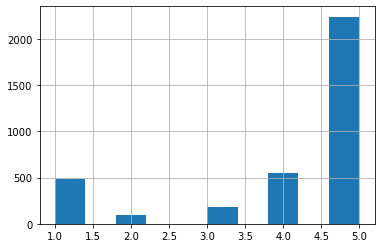

In [26]:
df.ratings.hist()

In [27]:
def rating_to_label(rating) :
  if rating >3:
    return 1
  else:
    return 0
df['y'] = df['ratings'].apply(lambda x : rating_to_label(x))

In [28]:
df

,date,comment,ratings,ko_text,nouns,y
0,2021-03-10,정확한 시간에 배달되어 만족합니다.,4,정확한 시간에 배달되어 만족합니다,[정확],1
1,2021-03-10,간편해서 좋아요,5,간편해서 좋아요,[간편],1
2,2021-03-10,신선한 제품을 빠른 배송과 가격도 만족할수 있어 좋아요.,5,신선한 제품을 빠른 배송과 가격도 만족할수 있어 좋아요,"[배송, 가격]",1
3,2021-03-10,상품의 질이 다른 오픈마켓 보다 좋네요~퀄리티가 달라요 특히 음식 시켜보니 믿음이 가네요,5,상품의 질이 다른 오픈마켓 보다 좋네요퀄리티가 달라요 특히 음식 시켜보니 믿음이 가네요,"[오픈, 오픈마켓, 퀄리티, 믿음]",1
4,2021-03-10,추. ㅊ ..ㅓ.ㅇ .ㅣ : ( 222444 )친환경 재료에 신선한 완전 최고에요....,5,추 ㅊ ㅓㅇ ㅣ 친환경 재료에 신선한 완전 최고에요상품마다 별점 주는 게 있으...,"[별점, 판단, 스토어]",1
...,...,...,...,...,...,...
3543,2016-03-02,신선 품질좋은 장보기 정확하고 빠른 배송,5,신선 품질좋은 장보기 정확하고 빠른 배송,"[신선, 품질, 정확, 배송]",1
3544,2016-03-02,아이를 키우며 좋은 식자재에 대한 갈증이 있는데 이렇게 건강하고 신선한 먹거리를 쉽...,5,아이를 키우며 좋은 식자재에 대한 갈증이 있는데 이렇게 건강하고 신선한 먹거리를 쉽...,"[식자재, 컴퓨터, 부족, 앱이네]",1
3545,2016-03-02,"아는동생소개로알게된마켓컬리 늦게안게아쉬울정도ㅋㅋ제품퀄리티완젼좋고,포장배송완벽함!내눈...",5,아는동생소개로알게된마켓컬리 늦게안게아쉬울정도ㅋㅋ제품퀄리티완젼좋고포장배송완벽함내눈으로...,"[동생, 포장, 안보, 퀄리티, 포장배송, 배송, 배송오고, 소분, 경우, 가도]",1
3546,2016-03-02,샛별배송 정말 훌륭합니다. 컬리라면 무조건 믿고 주문~ ^^*,5,샛별배송 정말 훌륭합니다 컬리라면 무조건 믿고 주문,"[샛별배송, 배송]",1


In [29]:
df.y.value_counts()

1    2797
0     751
Name: y, dtype: int64

In [30]:
y= df['y']
X_train,X_test, y_train, y_test = train_test_split(tf_idf_vect, y, test_size = 0.2)

In [31]:
print(X_test.shape)

(710, 13452)


# 여기까지 

# 로지스틱 회귀

In [32]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver="lbfgs", max_iter=500)
lr.fit(X_train, y_train)
print("Test Accuracy: {}%".format(round(lr.score(X_test, y_test)*100,2)))

Test Accuracy: 80.42%


In [33]:
scores = cross_val_score(lr, tf_idf_vect, y, cv=10) # model, train, target, cross validation

print('cross-val-score \n{}'.format(scores))

print('cross-val-score.mean \n{:.3f}'.format(scores.mean()))

cross-val-score 
[0.78873239 0.7915493  0.7971831  0.78873239 0.7915493  0.7943662
 0.7971831  0.7915493  0.79096045 0.80225989]
cross-val-score.mean 
0.793


In [34]:
y_pred_lr = lr.predict(X_test)
print("Logistic Regression Classifier report: \n\n", classification_report(y_test, y_pred_lr))

Logistic Regression Classifier report: 

               precision    recall  f1-score   support

           0       0.50      0.01      0.03       139
           1       0.81      1.00      0.89       571

    accuracy                           0.80       710
   macro avg       0.65      0.51      0.46       710
weighted avg       0.75      0.80      0.72       710



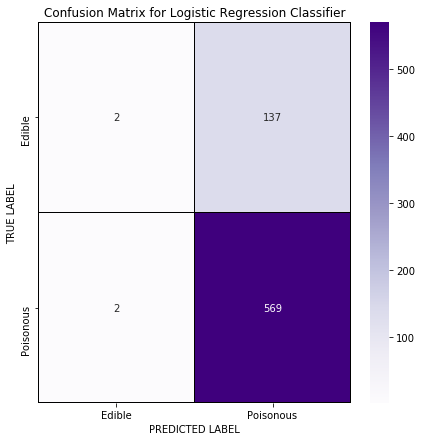

In [35]:
cm = confusion_matrix(y_test, y_pred_lr)
x_axis_labels = ["Edible", "Poisonous"]
y_axis_labels = ["Edible", "Poisonous"]
f, ax = plt.subplots(figsize =(7,7))
sns.heatmap(cm, annot = True, linewidths=0.2, linecolor="black", fmt = ".0f", ax=ax, cmap="Purples", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel("PREDICTED LABEL")
plt.ylabel("TRUE LABEL")
plt.title('Confusion Matrix for Logistic Regression Classifier')
#plt.savefig("lrcm.png", format='png', dpi=500, bbox_inches='tight')
plt.show()

In [36]:
# plt.rcParams['figure.figsize'] = [10,8]
# plt.bar(range(len(lr.coef_[0])), lr.coef_[0])

In [37]:
coef_pos_index = sorted(((value, index ) for index, value in enumerate(lr.coef_[0])), reverse=True)
coef_neg_index = sorted(((value,index) for index, value in enumerate(lr.coef_[0])), reverse= False)

In [38]:
for coef in coef_pos_index[:50]:
  print(invert_index_vectorizer[coef[1]])

신선
포장
빠르고
편하고
간편
빠른배송
편해요
품질
빠른
다양한
편리하고
할인
편하
배송
믿고
많고
퀄리티가
빨라서
질이
많아
친절하고
편해
빨라요
종류도
빠르
정확하고
쉽고
퀄리티
찜기능
저렴하게
가격
싸고
신뢰가
싱싱하고
많은
나아지는
친환경
저렴하고
택배가
ㅔ요
자세한
정확한
재미가
쉽게
신속하게
점점
쉬워요
좋고요
이벤트가
메뉴


In [39]:
for coef in coef_neg_index[:100]:
  print(invert_index_vectorizer[coef[1]])

안되
안됩니다
느리고
장바구니
없습니다
않고
만원이상
물품이
싼게
않았는데
없네요
하는
갑자기
원이라고
비싸게
최악의
ㅋㅋ
이라고
안오고
이유가
듭니당
지렸구요
최악최악최악최악
가질
없네
자체가
비싸네요
했는데도
봅니다
비쌈
그다지
아이디가
최악입니다
비싸내요
못하게
경기도권인데도
공유하신다면서요
노동환경개선하세요
쿠팡쓸게요
제도도
답변도
서비스는
못함
떠요
뒤에
삭제했습니다
아깝네요
연결이
창이
회원가입할때
실컷
뭔가요
매우만족
사람들은
괜히
못하고
하라고
떠서
로그인이
비싸고
터져서
오류로
없는데요
오배송
왔는데
건가요
원어치사야
하려는데
않다고
건지
말라는건지
비싸요
데이터를
저희집이
하루종일
최악임
별로에요
결국은
별로입니다
지역은
느리면
사라는건지
낫네요
한다고
아쉽네요
안씁니다
오류만
어이가없어서
택배
나오고
담긴것같은
대구
오전에
깨지고
뜹니다
경남지역은
울산이나
이라네요ㅎ
못사고
안드로이드


# 의사결정

In [40]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [41]:
y_pred_dt = dt.predict(X_test)
print("Decision Tree Classifier report: \n\n", classification_report(y_test, y_pred_dt))
print("Test Accuracy: {}%".format(round(dt.score(X_test, y_test)*100, 2)))

Decision Tree Classifier report: 

               precision    recall  f1-score   support

           0       0.55      0.29      0.38       139
           1       0.85      0.94      0.89       571

    accuracy                           0.82       710
   macro avg       0.70      0.62      0.64       710
weighted avg       0.79      0.82      0.79       710

Test Accuracy: 81.55%


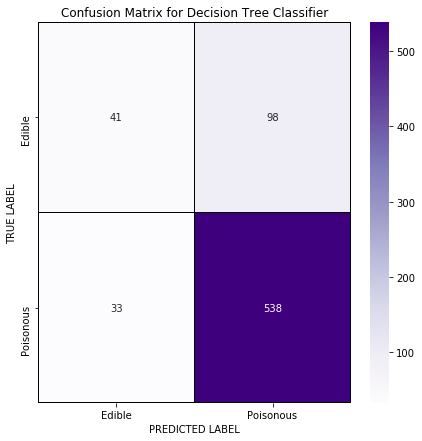

In [42]:
cm = confusion_matrix(y_test, y_pred_dt)
x_axis_labels = ["Edible", "Poisonous"]
y_axis_labels = ["Edible", "Poisonous"]
f, ax = plt.subplots(figsize =(7,7))
sns.heatmap(cm, annot = True, linewidths=0.2, linecolor="black", fmt = ".0f", ax=ax, cmap="Purples", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel("PREDICTED LABEL")
plt.ylabel("TRUE LABEL")
plt.title('Confusion Matrix for Decision Tree Classifier')
#plt.savefig("dtcm.png", format='png', dpi=500, bbox_inches='tight')
plt.show()

In [43]:
# plt.rcParams['figure.figsize'] = [10,8]
# plt.bar(range(len(dt.feature_importances_)), dt.feature_importances_)

In [44]:
coef_pos_index = sorted(((value, index ) for index, value in enumerate(dt.feature_importances_)), reverse=True)
coef_neg_index = sorted(((value,index) for index, value in enumerate(dt.feature_importances_)), reverse= False)

In [45]:
for coef in coef_pos_index[:100]:
  print(invert_index_vectorizer[coef[1]], coef[0])

안되 0.07013399625494952
신선 0.029549645604888458
배송 0.02130142317673795
장바구니 0.019277471058472925
간편 0.011116302007319098
할인 0.011090345255464287
않고 0.01030629057809958
안됩니다 0.010150437394162987
포장 0.008331915533318404
느리고 0.006990088797274647
편하고 0.006573402325664872
똑같은 0.006214595485969908
답변도 0.006182362106893599
품질 0.005829318961108299
빠르고 0.005580523043650765
만원이상 0.005400891803430948
느려요 0.005347492664174625
없습니다 0.005324508314035962
빠른배송 0.004946019460185556
못하고 0.0048713701794036515
원이라고 0.004849227587678652
입니다 0.004829924396968306
아깝네요 0.00482723562583
않았는데 0.0048053929306903324
없어서 0.00474507470380168
없네 0.0038667343624978505
쓰는 0.0038522068695896862
이라고 0.0038377610938283555
많고 0.0038267998510260436
낫네요 0.0038233964234837274
엉망입니다 0.0038091122525365268
비싸게 0.0037949079806190874
데이터를 0.0037807830129491225
연결이 0.003766736760269498
고객센터에 0.0037527686387854296
비쌈 0.003738878070103767
어이가없어서 0.003725064481174723
결국은 0.003711327304231399
시부터 0.0036976659767310243
택배 0.003658647133

In [46]:
for coef in coef_neg_index[:100]:
  print(invert_index_vectorizer[coef[1]],coef[0])

ㄱㅣ회를 0.0
ㅇㅈㅇㅈ홧팅 0.0
ㅊㅜㅊㅓㄴㅇㅣㄴ 0.0
ㅊㅜ우쳐햐시면 0.0
ㅊㅜ쳐햐시면 0.0
ㅋㄹ 0.0
ㅋㅋㅋ 0.0
ㅋㅋㅋㅋ 0.0
ㅋㅋㅋㅋㅋㄱ 0.0
ㅋㅋㅋㅋㅋㅋ 0.0
ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ 0.0
ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ새로가입해서 0.0
ㅋㅋㅋㅋㅋ웃긴 0.0
ㅋㅋㅋㅋ아니 0.0
ㅋㅋㅋ그딴개소리는 0.0
ㅋㅋ전화 0.0
ㅋㅜ팡 0.0
ㅋ그지같은 0.0
ㅋ망하길기도합니다 0.0
ㅎㅎㅎ 0.0
ㅎㅎㅎㅎ 0.0
ㅎㅎㅎㅎ이럴거면 0.0
ㅎㅎ아침에 0.0
ㅎㅎ장보기즐거움 0.0
ㅏ고싶어ㅈ 0.0
ㅏ서 0.0
ㅏ지는 0.0
ㅏ켓컬 0.0
ㅏ켓컬리 0.0
ㅐ요 0.0
ㅐ월째 0.0
ㅓ들었고 0.0
ㅓ요 0.0
ㅓ지ㄴ 0.0
ㅓ지네요 0.0
ㅔ요 0.0
ㅜㅜㅜ 0.0
ㅜㅜㅜㅜ 0.0
ㅜㅜㅜㅜㅜ 0.0
ㅜㅜ대실망이예요 0.0
ㅜㅠㅋㅋㅋㅋㅋ개수좀 0.0
ㅠㅜ 0.0
ㅠㅜㅠㅜㅠ 0.0
ㅠㅠㅠ 0.0
ㅠㅠㅠㅠ 0.0
ㅠㅠㅠㅠㅜㅠㅜ 0.0
ㅠㅠㅠㅠㅠ 0.0
ㅠㅠㅠㅠㅠㅠㅠ 0.0
ㅠㅠㅠ얼어요 0.0
ㅠㅠ해결좀다른분들 0.0
ㅠㅡㅠ 0.0
ㅠ그리고 0.0
ㅡㅡㅋ 0.0
ㅡㅡㅡㅡㅡ 0.0
ㅣ네요 0.0
ㅣ당로또번호을 0.0
ㅣ더라고요 0.0
ㅣ용하고 0.0
ㅣ용하고있습ㄴ 0.0
ㅣ용하고있습니다 0.0
ㅣ적립오류도 0.0
가고 0.0
가고편리성타 0.0
가공식품 0.0
가공식품등 0.0
가관이네요 0.0
가구이다보니 0.0
가기도 0.0
가길 0.0
가까운 0.0
가까운데 0.0
가까이 0.0
가까이오면 0.0
가끔먹어보지 0.0
가끔사용하는데 0.0
가끔씩 0.0
가끔오고 0.0
가난해져만 0.0
가네요 0.0
가네요다만 0.0
가는 0.0
가는것도 0.0
가는데 0.0
가능도 0.0
가능지역이 0.0
가능지역이라고 0.0
가능하게 0.0
가능하고 0.0
가능하고저는 0.0
가능하네요 0.0
가능하니불편하기가 0.0
가능하다고 0.0
가능하다길래 0.0
가능하다네요 0.0
가능하다는 0.0
가능하며 0.0
가능하면좋겠어요 0.0
가능한거죠 0.0
가능한것이 0.0
가능한게 0.0

# KNN

In [47]:
from sklearn.neighbors import KNeighborsClassifier
best_Kvalue = 0
best_score = 0
for i in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    if knn.score(X_test, y_test) > best_score:
        best_score = knn.score(X_train, y_train)
        best_Kvalue = i
        
print("Best KNN Value: {}".format(best_Kvalue))
print("Test Accuracy: {}%".format(round(best_score*100,2)))

Best KNN Value: 1
Test Accuracy: 98.94%


In [48]:
y_pred_knn = knn.predict(X_test)
print("KNN Classifier report: \n\n", classification_report(y_test, y_pred_knn))


KNN Classifier report: 

               precision    recall  f1-score   support

           0       0.00      0.00      0.00       139
           1       0.80      1.00      0.89       571

    accuracy                           0.80       710
   macro avg       0.40      0.50      0.45       710
weighted avg       0.65      0.80      0.72       710



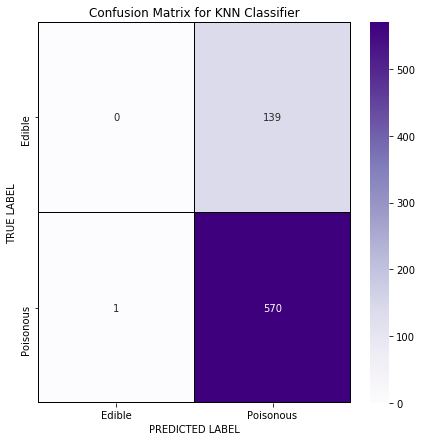

In [49]:
cm = confusion_matrix(y_test, y_pred_knn)
x_axis_labels = ["Edible", "Poisonous"]
y_axis_labels = ["Edible", "Poisonous"]
f, ax = plt.subplots(figsize =(7,7))
sns.heatmap(cm, annot = True, linewidths=0.2, linecolor="black", fmt = ".0f", ax=ax, cmap="Purples", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel("PREDICTED LABEL")
plt.ylabel("TRUE LABEL")
plt.title('Confusion Matrix for KNN Classifier')
#plt.savefig("knncm.png", format='png', dpi=500, bbox_inches='tight')
plt.show()

# svm

In [50]:
from sklearn.svm import SVC
svm = SVC(random_state=42, gamma="auto")
svm.fit(X_train, y_train)
print("Test Accuracy: {}%".format(round(svm.score(X_test, y_test)*100, 2)))


Test Accuracy: 80.42%


In [51]:
y_pred_svm = svm.predict(X_test)
print("SVM Classifier report: \n\n", classification_report(y_test, y_pred_svm))

SVM Classifier report: 

               precision    recall  f1-score   support

           0       0.00      0.00      0.00       139
           1       0.80      1.00      0.89       571

    accuracy                           0.80       710
   macro avg       0.40      0.50      0.45       710
weighted avg       0.65      0.80      0.72       710



C:\Users\jby\AppData\Local\Continuum\anaconda3\envs\textmining\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


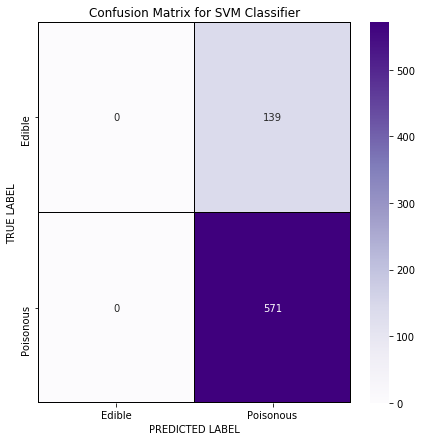

In [52]:
cm = confusion_matrix(y_test, y_pred_svm)
x_axis_labels = ["Edible", "Poisonous"]
y_axis_labels = ["Edible", "Poisonous"]
f, ax = plt.subplots(figsize =(7,7))
sns.heatmap(cm, annot = True, linewidths=0.2, linecolor="black", fmt = ".0f", ax=ax, cmap="Purples", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel("PREDICTED LABEL")
plt.ylabel("TRUE LABEL")
plt.title('Confusion Matrix for SVM Classifier')
#plt.savefig("svmcm.png", format='png', dpi=500, bbox_inches='tight')
plt.show()

# 랜덤포레스트

In [53]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
print("Test Accuracy: {}%".format(round(rf.score(X_test, y_test)*100, 2)))

Test Accuracy: 81.27%


In [54]:
y_pred_rf = rf.predict(X_test)
print("Random Forest Classifier report: \n\n", classification_report(y_test, y_pred_rf))

Random Forest Classifier report: 

               precision    recall  f1-score   support

           0       0.69      0.08      0.14       139
           1       0.82      0.99      0.89       571

    accuracy                           0.81       710
   macro avg       0.75      0.54      0.52       710
weighted avg       0.79      0.81      0.75       710



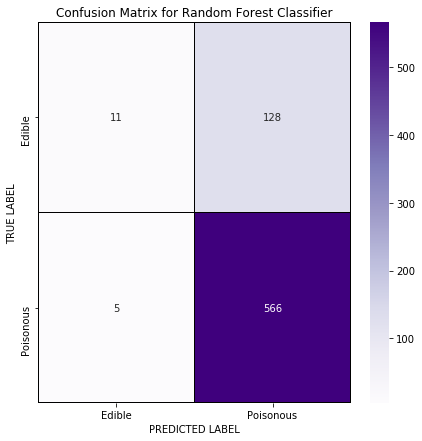

In [55]:
cm = confusion_matrix(y_test, y_pred_rf)
x_axis_labels = ["Edible", "Poisonous"]
y_axis_labels = ["Edible", "Poisonous"]
f, ax = plt.subplots(figsize =(7,7))
sns.heatmap(cm, annot = True, linewidths=0.2, linecolor="black", fmt = ".0f", ax=ax, cmap="Purples", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel("PREDICTED LABEL")
plt.ylabel("TRUE LABEL")
plt.title('Confusion Matrix for Random Forest Classifier');
#plt.savefig("rfcm.png", format='png', dpi=500, bbox_inches='tight')
plt.show()

In [56]:
# plt.rcParams['figure.figsize'] = [10,8]
# plt.bar(range(len(rf.feature_importances_)), rf.feature_importances_)

In [57]:
coef_pos_index = sorted(((value, index ) for index, value in enumerate(rf.feature_importances_)), reverse=True)
coef_neg_index = sorted(((value,index) for index, value in enumerate(rf.feature_importances_)), reverse= False)

In [58]:
for coef in coef_pos_index[:100]:
  print(invert_index_vectorizer[coef[1]], coef[0])

안되 0.029527145116824926
신선 0.011932784108078607
배송 0.007884749825573394
안됩니다 0.007646603685940262
장바구니 0.006228627553356708
느리고 0.005637998958052274
포장 0.005140714696857347
없습니다 0.0046064200948568055
빠르고 0.004143011751924351
만원이상 0.003417278346062017
않고 0.003321988961604788
간편 0.0028715358737286586
편하고 0.0026358876483137455
갑자기 0.0024976047468740197
비싸게 0.0023823675273783144
종류가 0.002337599452638726
많아 0.002290769350098605
ㅋㅋ 0.002201567434454414
비싸요 0.0021909646744644974
물품이 0.0021597703694827943
품질 0.002137369132607643
검색 0.002113994008582893
이라고 0.0020744413442419086
없네요 0.0020269295672452154
지렸구요 0.0020249028508533416
듭니당 0.0019949472402196232
원이라고 0.0019911015326755043
최악최악최악최악 0.0019569979503250147
노동환경개선하세요 0.0019523361729204614
않았는데 0.0019345412570448087
빠른배송 0.0019094823337249783
못하고 0.0018901291880192672
공유하신다면서요 0.0018582329813047805
싼게 0.0018549975166270876
택배 0.0018226209752065577
비쌈 0.001807155143354036
없네 0.0017973664564182553
고객센터는 0.001795666140360215
할인 0.001753980657

In [59]:
for coef in coef_neg_index[:100]:
  print(invert_index_vectorizer[coef[1]])

ㄱㅣ회를
ㅇㅈㅇㅈ홧팅
ㅋㅋㅋㅋㅋㅋ
ㅋㅋㅋ그딴개소리는
ㅋㅜ팡
ㅋ그지같은
ㅋ망하길기도합니다
ㅎㅎㅎㅎ
ㅏ고싶어ㅈ
ㅏ서
ㅐ요
ㅓ요
ㅓ지ㄴ
ㅓ지네요
ㅜㅠㅋㅋㅋㅋㅋ개수좀
ㅠㅜㅠㅜㅠ
ㅠㅠㅠㅠㅠㅠㅠ
ㅠㅠㅠ얼어요
ㅠㅠ해결좀다른분들
ㅠ그리고
ㅡㅡㅡㅡㅡ
ㅣ더라고요
ㅣ용하고
가공식품등
가길
가까이오면
가끔먹어보지
가능하다네요
가능한거죠
가능한지
가능한지요
가능할까
가능할듯합니다
가능합니다
가득
가루
가만히만
가방으로
가보니
가상계좌이체도
가성비가좋아요
가성비좋게
가성비좋은
가슴을
가야되는데
가정에선
가져가던걸
가져간다해놓고
가져간대서
가져간더니
가져간줄
가져다
가져야
가족들
가족위해
가족이
가지고
가지런히
가지만
가지셔야
가지수도
각자의
간결한
간단결제
간단하고
간단한
간식들과
간적이
갇혀지내는데
갈시간이
갈아
갈아타려고요
갈아탈
갈아탈걸
갈아탔다가
갈아탔어요
갈증이
갈치
감당할
감동생산자와
감동이에요
감동합니다
감동했어요
감수해야
감싸는거면
감아
감탄하고
감탄했네요
갑니디ㅣ
값도
값은
갔거나
강아지에겐
강요하지
강제적으로
강조하며
갖다줘야지
같기도
같네요그래도
같네용
